# Mario + Reinforcement Learning

https://github.com/nicknochnack/MarioRL/blob/main/Mario%20Tutorial.ipynb

^^^ gymnasium is now outdated, so most of this code wont work

In [1]:
import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT


In [2]:
SIMPLE_MOVEMENT

[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

In [3]:
# setting up env

env = gym_super_mario_bros.make('SuperMarioBros-v0')
env = JoypadSpace(env, SIMPLE_MOVEMENT)

/opt/homebrew/Caskroom/miniforge/base/envs/rl-env/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(


In [4]:
env.observation_space.shape

(240, 256, 3)

In [5]:
env.action_space

Discrete(7)

In [6]:
def func():
    # Create a flag - restart or not
    done = True
    # Loop through each frame in the game
    for step in range(100000): 
        # Start the game to begin with 
        if done: 
            # Start the gamee
            env.reset()
        # Do random actions
        state, reward, done, info = env.step(env.action_space.sample())
        # Show the game on the screen
        env.render()

    # Close the game
    env.close()

In [7]:
state = env.reset()

/opt/homebrew/Caskroom/miniforge/base/envs/rl-env/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:195: UserWarning: WARN: The result returned by `env.reset()` was not a tuple of the form `(obs, info)`, where `obs` is a observation and `info` is a dictionary containing additional information. Actual type: `<class 'numpy.ndarray'>`
  logger.warn(


In [13]:
state.shape

(240, 256, 3)

### preprocessing

- bad input creates a bad ai, you need to preprocess data that the ai can learn from
- mario will use grey scale and frame stacking
- grey scale allows a faster ai and faster learning
- framestacking giving the ai context / giving it more memory

In [17]:
# wrapper for gray scale and frame stacking
from gym.wrappers import GrayScaleObservation, FrameStack
# vectorized wrapper
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv
# matplotlib
from matplotlib import pyplot as plt

In [18]:
# setting up the base environment

env = gym_super_mario_bros.make('SuperMarioBros-v0')

# simplify the action space 

env = JoypadSpace(env, SIMPLE_MOVEMENT)

/opt/homebrew/Caskroom/miniforge/base/envs/rl-env/lib/python3.9/site-packages/gym/envs/registration.py:555: UserWarning: WARN: The environment SuperMarioBros-v0 is out of date. You should consider upgrading to version `v3`.
  logger.warn(


In [19]:
# applying gray scale

env = GrayScaleObservation(env, keep_dim=True)

In [21]:
# wrapping inside the dummy vectorized environment

env = DummyVecEnv([lambda: env])

/opt/homebrew/Caskroom/miniforge/base/envs/rl-env/lib/python3.9/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


In [22]:
# stack the frames
env = VecFrameStack(env, 4, channels_order="last")

In [27]:
state.shape
# as you can see the number of colour channels is reduced to one

(240, 256, 3)

In [ ]:
state = env.reset()

TypeError: reset() got an unexpected keyword argument 'seed'

In [29]:
state.shape

(240, 256, 3)

In [24]:
state, reward, done, info = env.step([env.action_space.sample()])

ResetNeeded: Cannot call env.step() before calling env.reset()

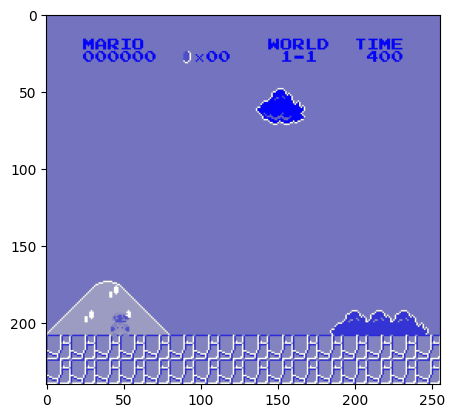

In [ ]:
plt.imshow(state[0])

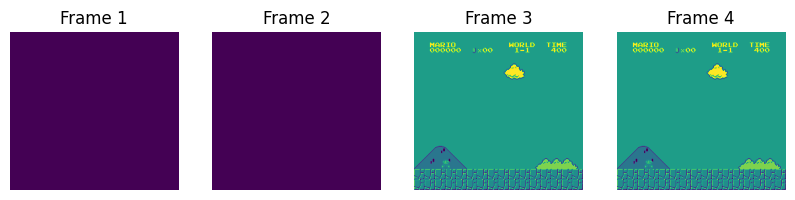

In [ ]:
plt.figure(figsize=(10,8))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0,:,:,idx])
    plt.axis('off')
    plt.title(f'Frame {idx+1}')
plt.show()

### building the model

- reinforcement learning needs vectors to learn
- stable_baselines is the library that does reinforcement learning
- the specific rl algorithm : proxy policy optimization

AREA
A - agent, R - reward, E - environment, A - action

- with reinforcement learning, the goal is that the agent is rewarded or punished based on its actions

In [ ]:
# using ppo algorithm from stable baselines 3

import os

from stable_baselines3 import PPO
# basecallback is used to reload and save previous models
from stable_baselines3.common.callbacks import BaseCallback

In [ ]:
# taken from the github repository

class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [ ]:
CHECKPOINT_DIR = './data/mario/train'
LOG_DIR = './data/mario/logs'

In [ ]:
# setting up the callback
# saving the model every 10000 steps
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR) 

In [ ]:
# creating the PPO model

model = PPO(policy='CnnPolicy',
            env = env, 
            verbose = 1, # you get information when you are trianing
            tensorboard_log=LOG_DIR, # logging the training
            learning_rate=0.000001, 
            n_steps = 512) # n_steps is the number of steps to run for each environment per update

# as you can see, the hardest part is to actually get good data for training


Using cpu device
Wrapping the env in a VecTransposeImage.


In [ ]:
# training the model

model.learn(total_timesteps=1000000, 
            callback=callback)



ImportError: Trying to log data to tensorboard but tensorboard is not installed.

### running the model